In [83]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp
import os

from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import get_wavelen, apply_psf, simulate_projection
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

from multislice import Material, make_fiber_phantom, simulate_multislice


In [3]:

plt.rcParams.update({
    'figure.dpi': 300,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.major.size':2,
    'ytick.major.size':2,
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units, color='k'):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False, color=color)
    ax.add_artist(scalebar)

class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

tissue = Material('tissue', 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)', 1.06)
bone = Material('bone', 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)', 1.92)
fat = Material('adipose', 'H(11.4)C(59.8)N(0.7)O(27.8)Na(0.1)S(0.1)Cl(0.1)', 0.95)
alu = Material('aluminum', 'Al(100.0)', 2.699)
pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
water = Material('water', 'H(11.2)O(88.8)', 1.0)
calcium = Material('calcium', 'Ca(100.0)', 1.526)
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)
# glass = Material('glass', 'O(53.9559)Na(2.8191)Al(1.1644)Si(37.7220)K(0.3321)', 2.230)  ## incorrect!
glass = Material('glass', 'B(4.0064)O(53.9559)Na(2.8191)Al(1.1644)Si(37.7220)K(0.3321)', 2.230)
breast = Material('breast tissue', 'C(33.2)N(3.0)O(52.7)Na(0.1)P(0.1)S(0.2)Cl(0.1)', 1.02)

def NF(a, E, z):
    return a**2 / (get_wavelen(E)*z)

def print_NF(a, E, z):
    print(f'a={a*1e6:.0f} um, E={E:.0f} keV, z={z*1e2:2.0f} cm : NF={NF(a, E, z):.0f}')


def make_speck_phantom(N, Nz, dx, speck_radius, energy, tspeck=1.0, speck_material=glass, background_material=pmma):

    fov = N*dx
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)
    speck_shift = 0.15*fov               # Cailey changed this by hand from 0.15*fov
    assert speck_shift > speck_radius
    
    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(int(tspeck*Nz)):
        for xc in [-speck_shift, speck_shift]:
            for yc in [-speck_shift, speck_shift]:
                mask = np.where(((X-xc)**2 + (Y-yc)**2 < speck_radius**2))  
                obj[z][mask] = 1
                # adjust to decrease in thickness

    matdict = {0: background_material, 1: speck_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta


def make_sphere_phantom(N, Nz, dx, dz, sphere_radius, energy, sphere_material=breast, background_material=pmma):

    fov = N*dx
    fovz = Nz*dz
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    zcoords = np.abs(np.linspace(-fovz/2, fovz/2, Nz))
    # field of view should shrink
    # accidentally shrinks sphere, sphere is too large
    Z, X, Y = np.meshgrid(zcoords, coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    mask = np.where((X**2 + Y**2 + Z**2 < sphere_radius**2)) 
    mask = (mask[1], mask[0], mask[2])  # ? works
    
    obj[mask] = 1

    matdict = {0: background_material, 1: sphere_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta



In [27]:
fov*1e3

0.64

## Parameters
- All distances are in units [m]
- All energies in [keV]

Reasoning behind parameter choices:

- energy = 20 keV ~ rough average for a mammography energy spectrum.
- thickness = 5 cm ~ reasonable compressed breast thickness.
- detector pixels = 5 um ~ very high res but still shows fringe effects.
- phantom pixels = approx 0.5 um ~ much higher resolution than the detector for accurate simulation.
- detector psf = None ~ ignoring this effect for now, need to check implementation.

In [45]:
figd = 'figs_aapm2025_multislice/'
os.makedirs(figd, exist_ok=True)


'img_64_100mm'


### 64x64 - 0 cm ###################
detector px = 10.0 um, E = 20 keV, thickness = 50.0 mm ==> NF = 32.26
fiber width = 25 micron
fiber width = 50 micron
fiber width = 100 micron
speck thickness = 10 um
speck thickness = 20 um
speck thickness = 40 um
sphere radius = 100 micron
sphere radius = 150 micron
sphere radius = 200 micron


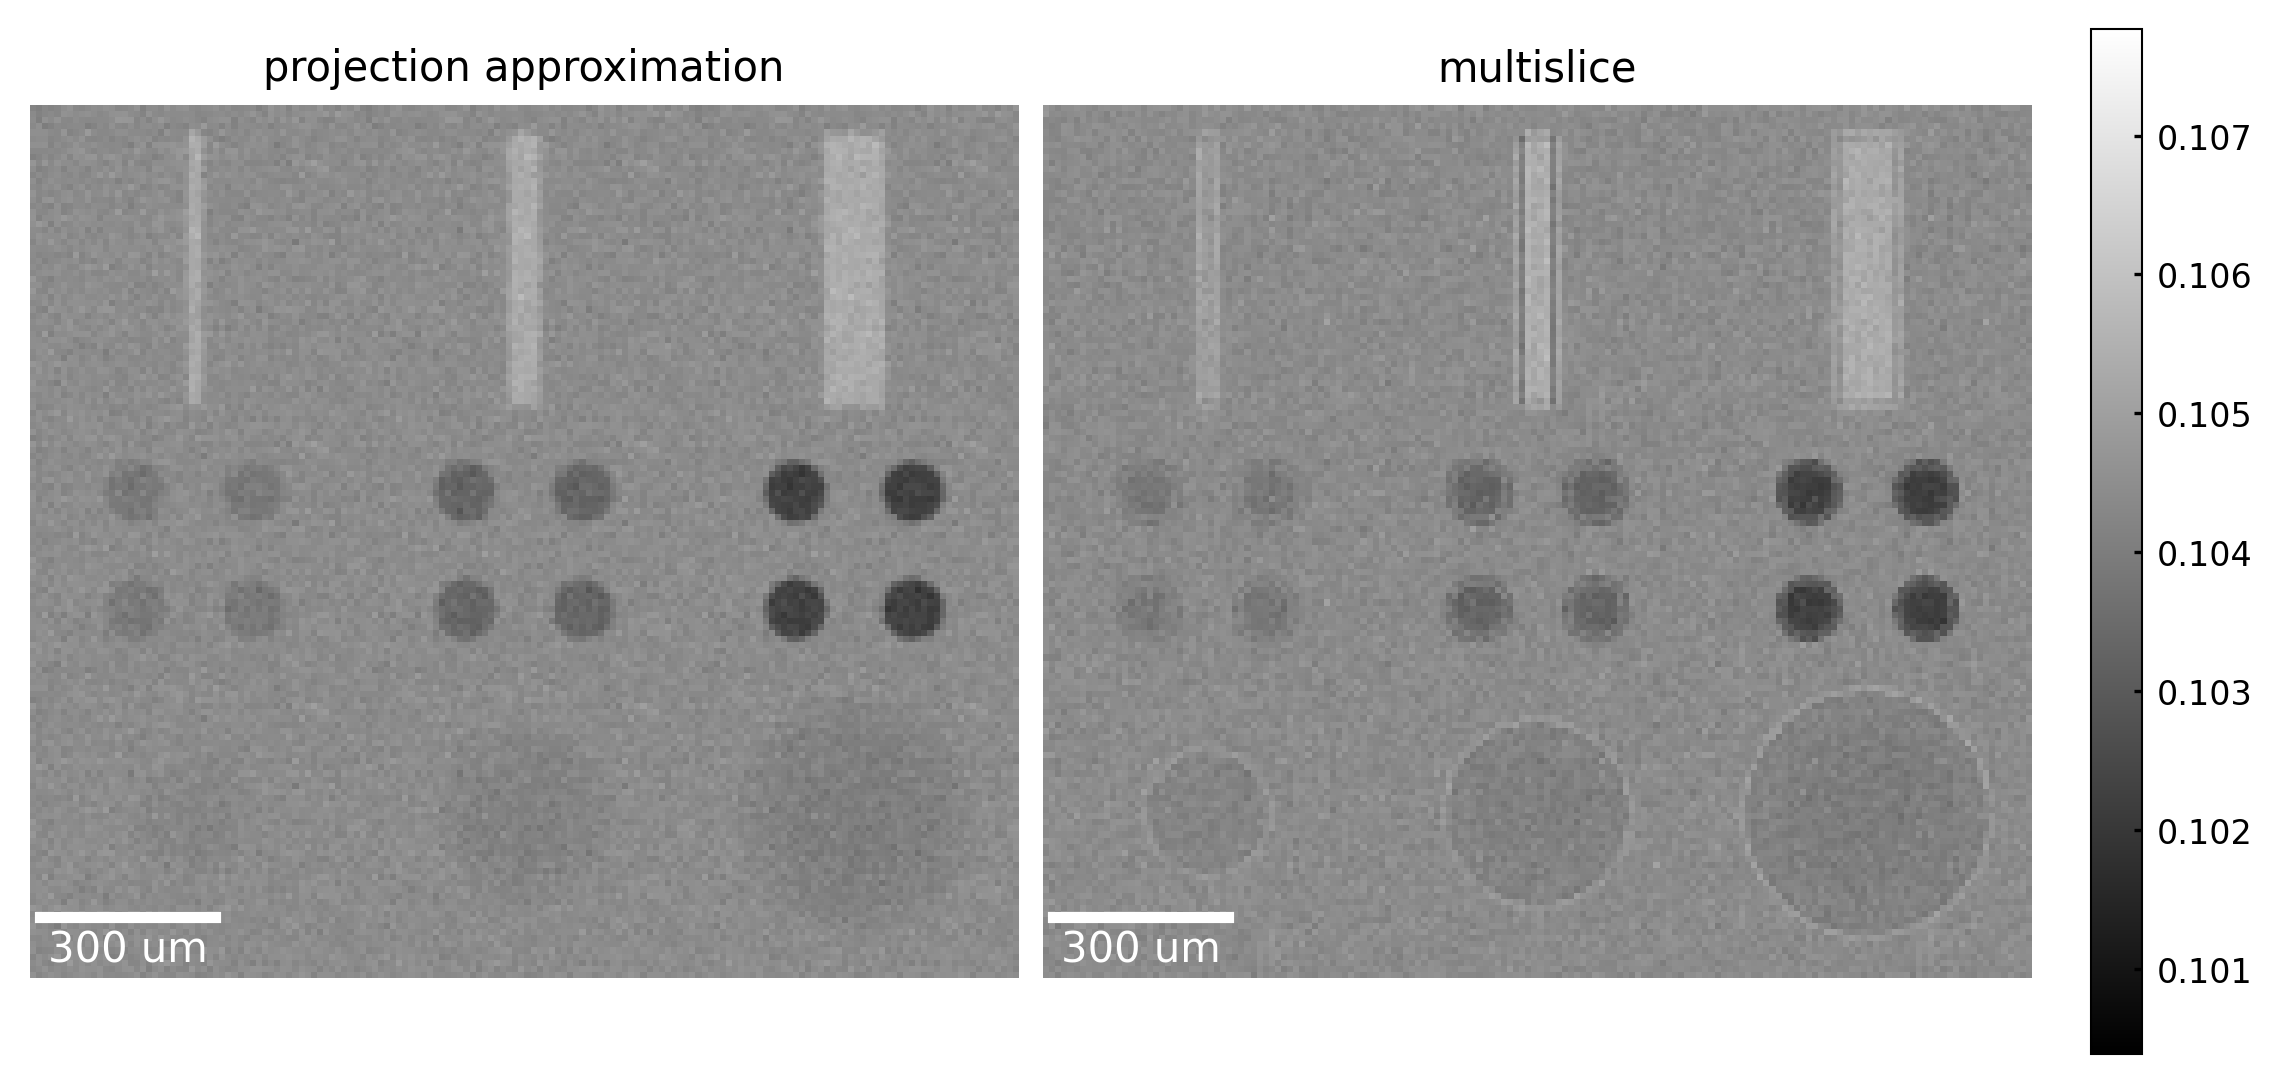

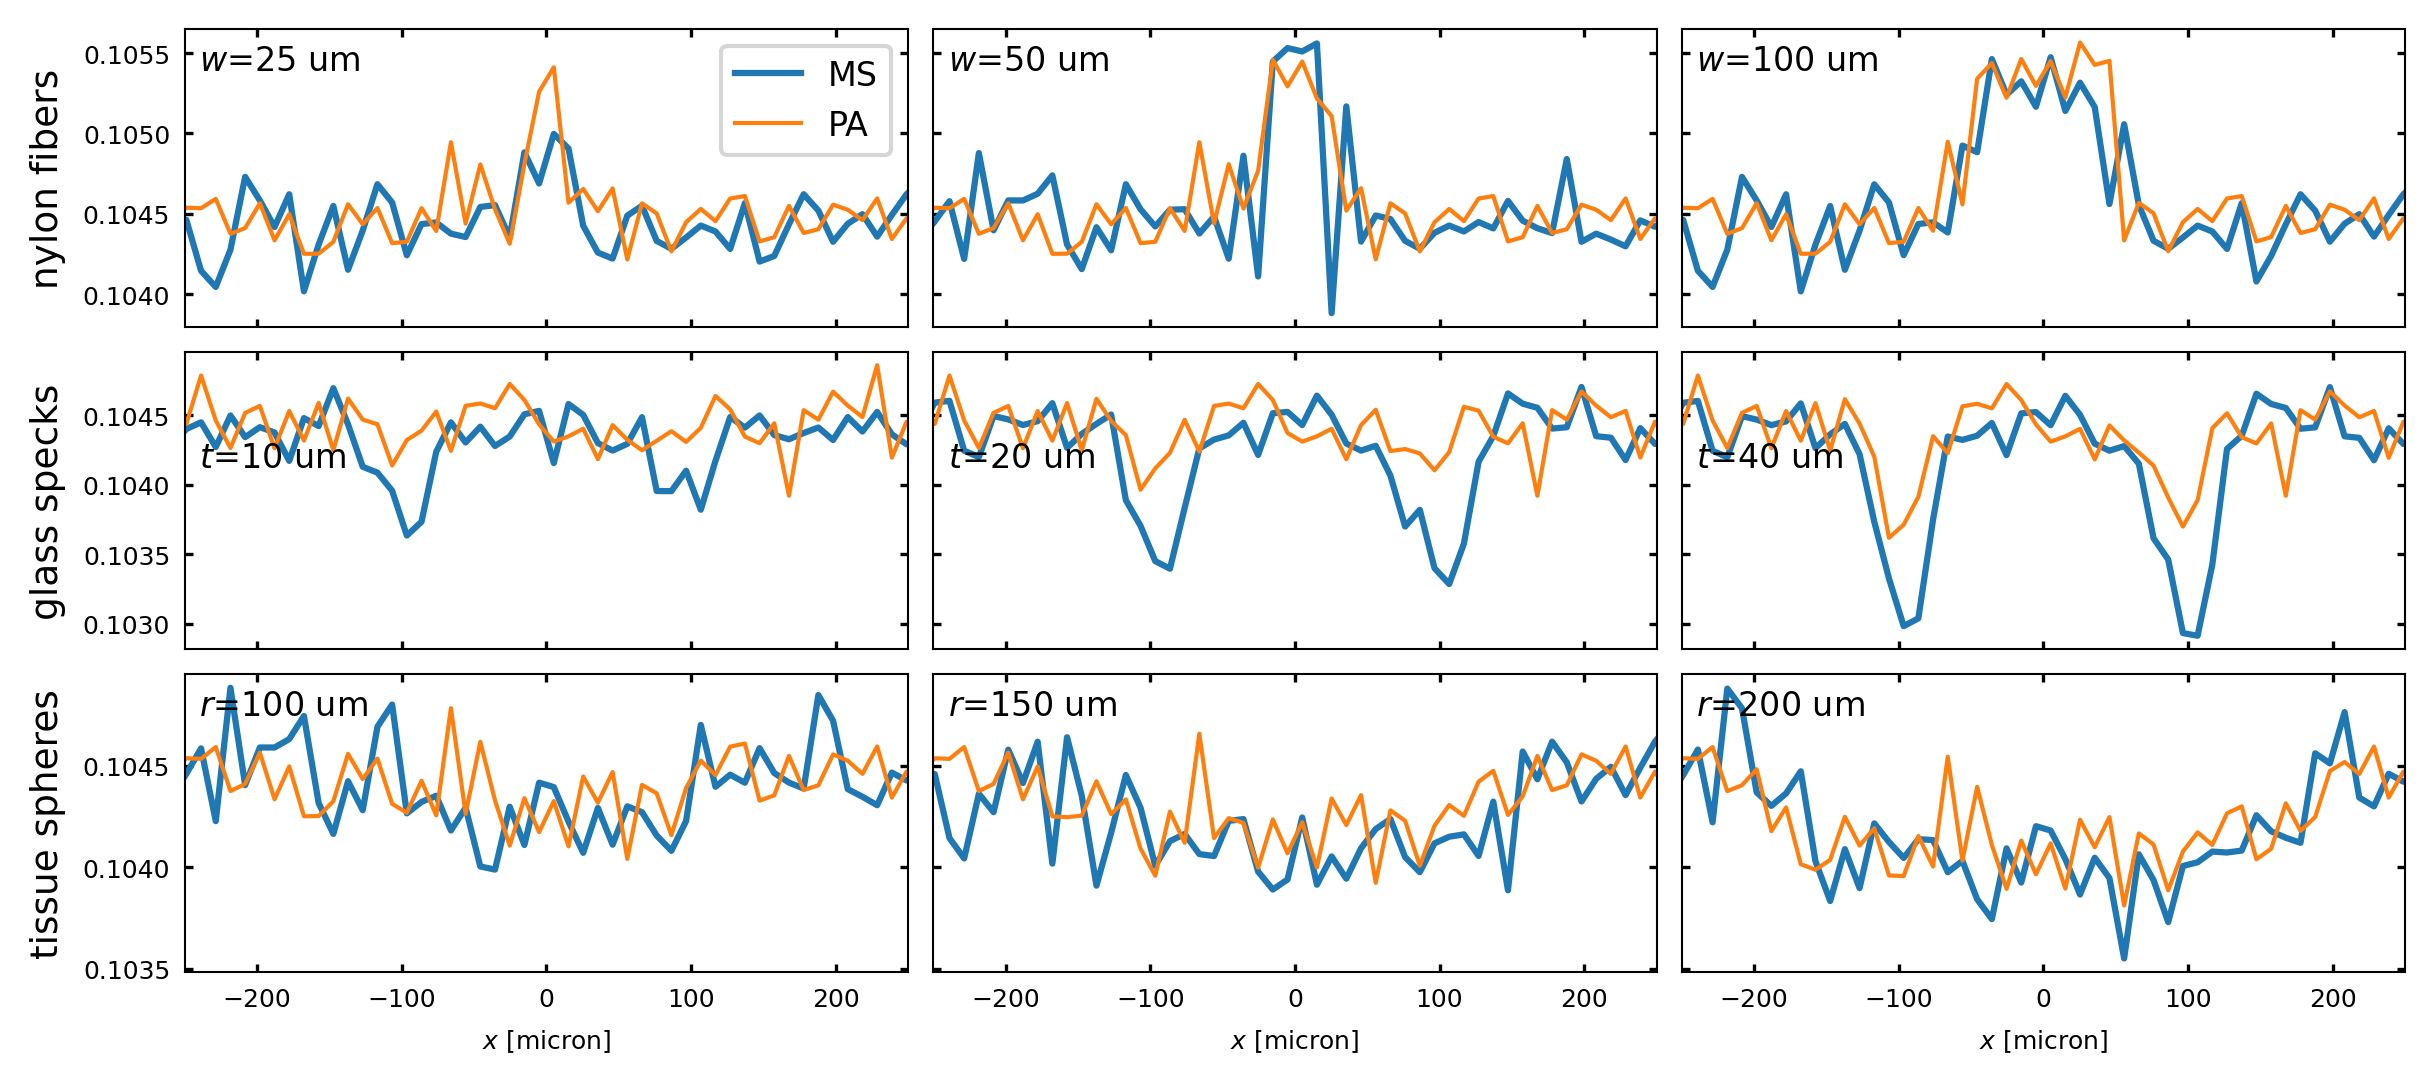


### 64x64 - 5 cm ###################
detector px = 10.0 um, E = 20 keV, thickness = 50.0 mm ==> NF = 32.26
fiber width = 25 micron
fiber width = 50 micron
fiber width = 100 micron
speck thickness = 10 um
speck thickness = 20 um
speck thickness = 40 um
sphere radius = 100 micron
sphere radius = 150 micron
sphere radius = 200 micron


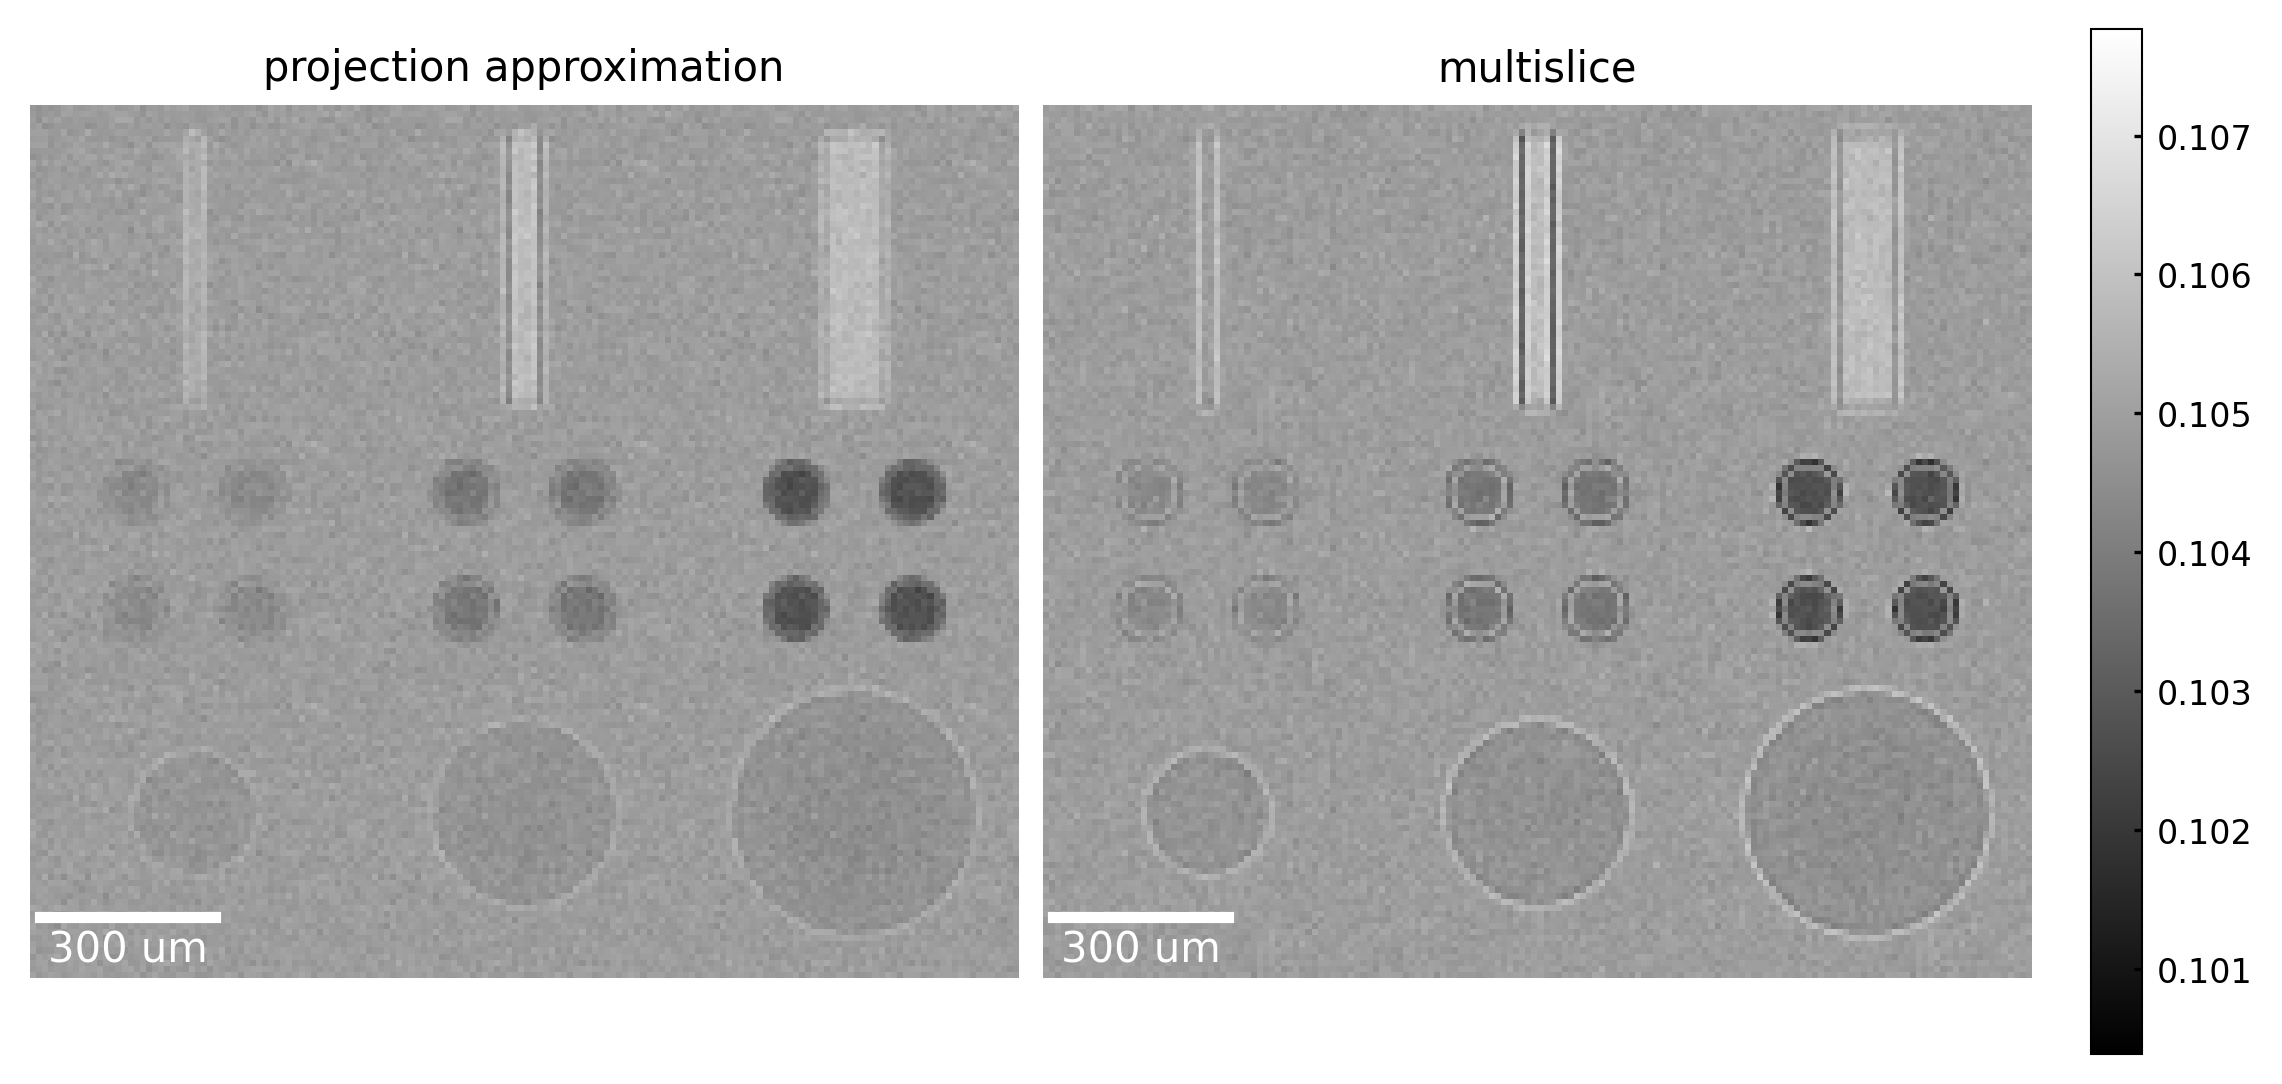

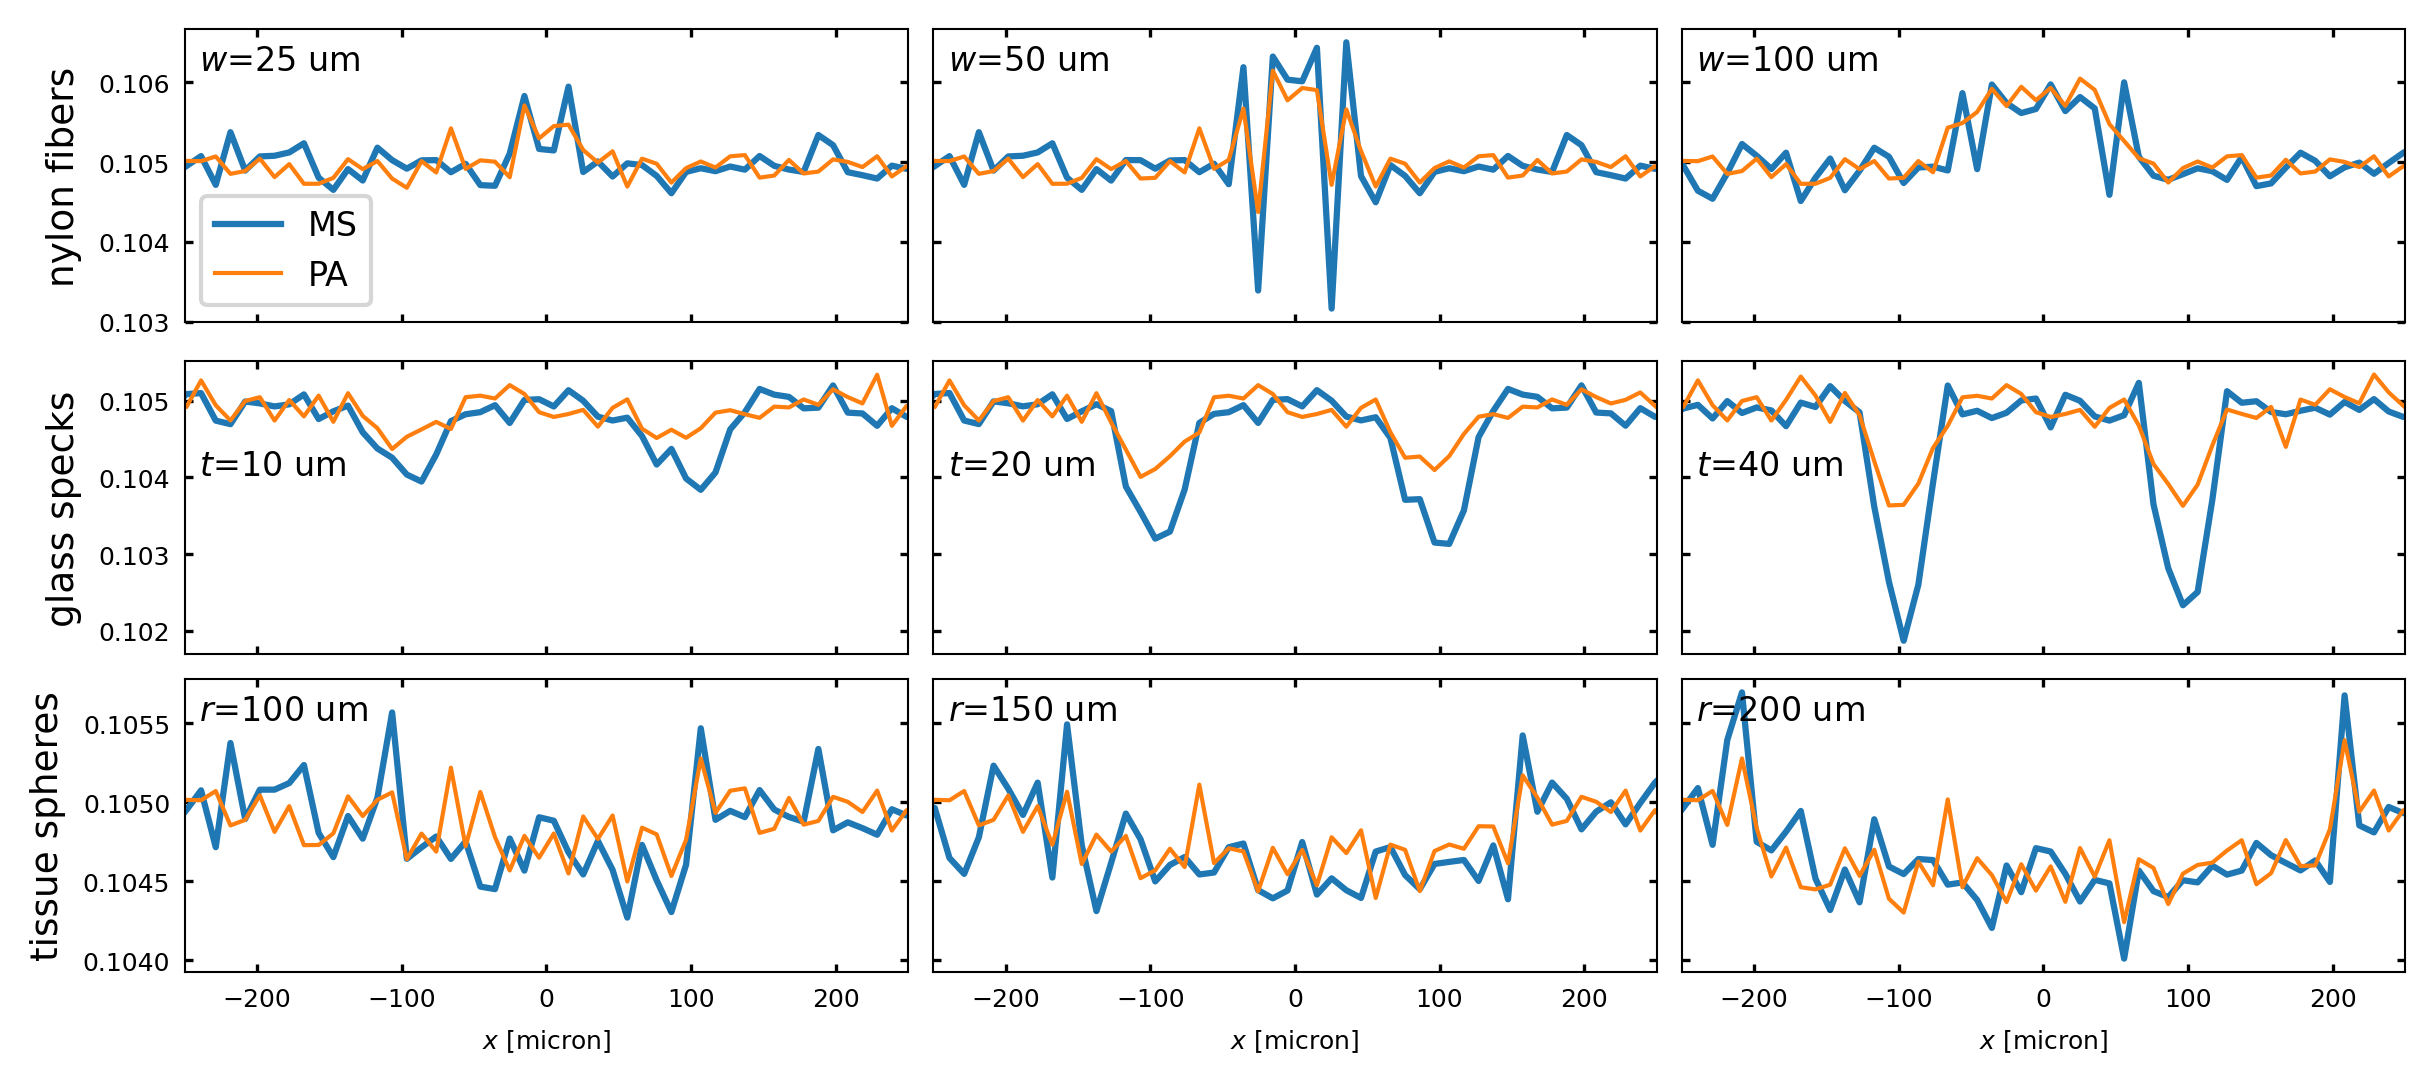


### 64x64 - 10 cm ###################
detector px = 10.0 um, E = 20 keV, thickness = 50.0 mm ==> NF = 32.26
fiber width = 25 micron
fiber width = 50 micron
fiber width = 100 micron
speck thickness = 10 um
speck thickness = 20 um
speck thickness = 40 um
sphere radius = 100 micron
sphere radius = 150 micron
sphere radius = 200 micron


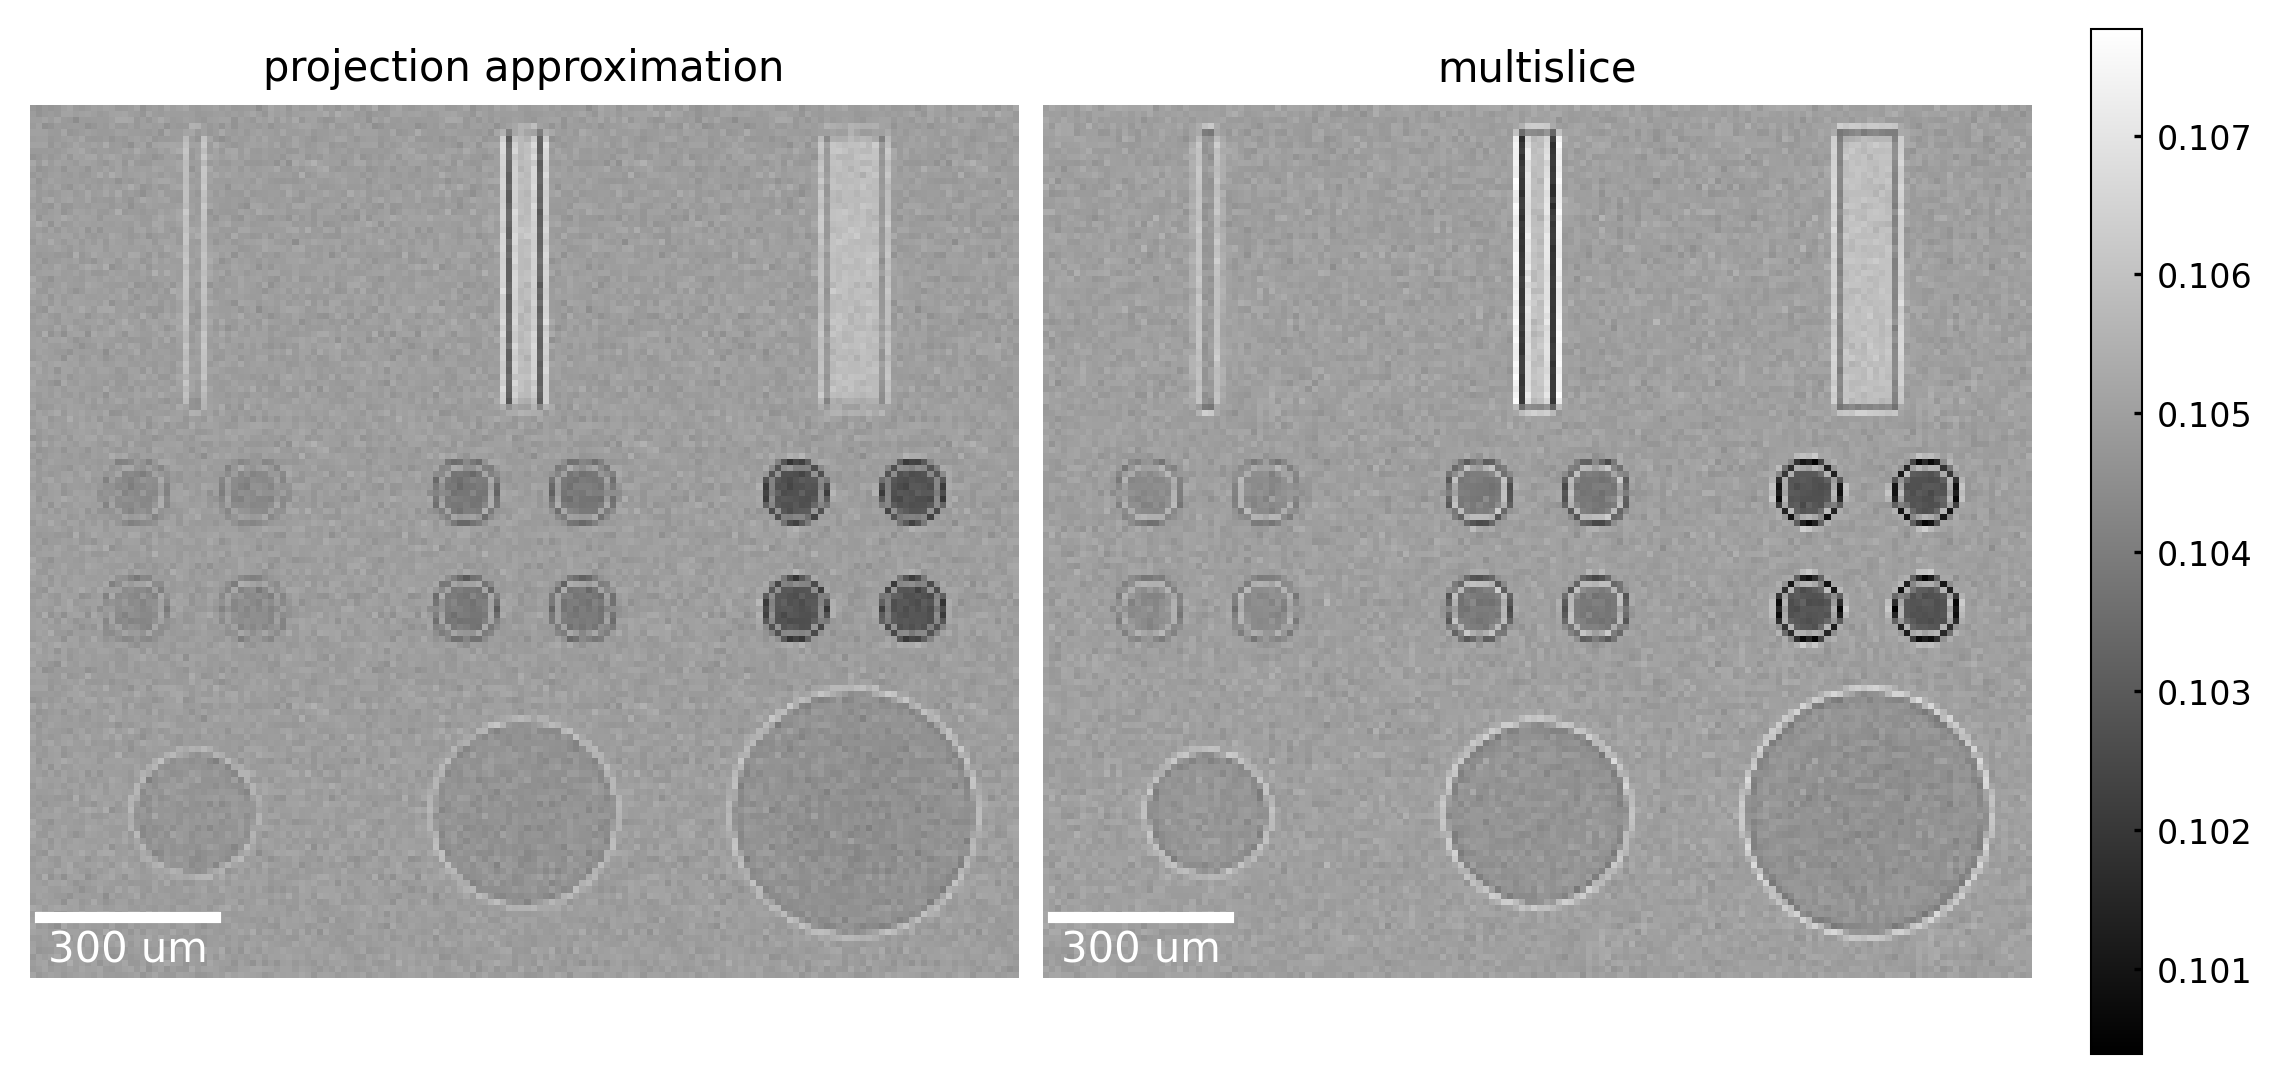

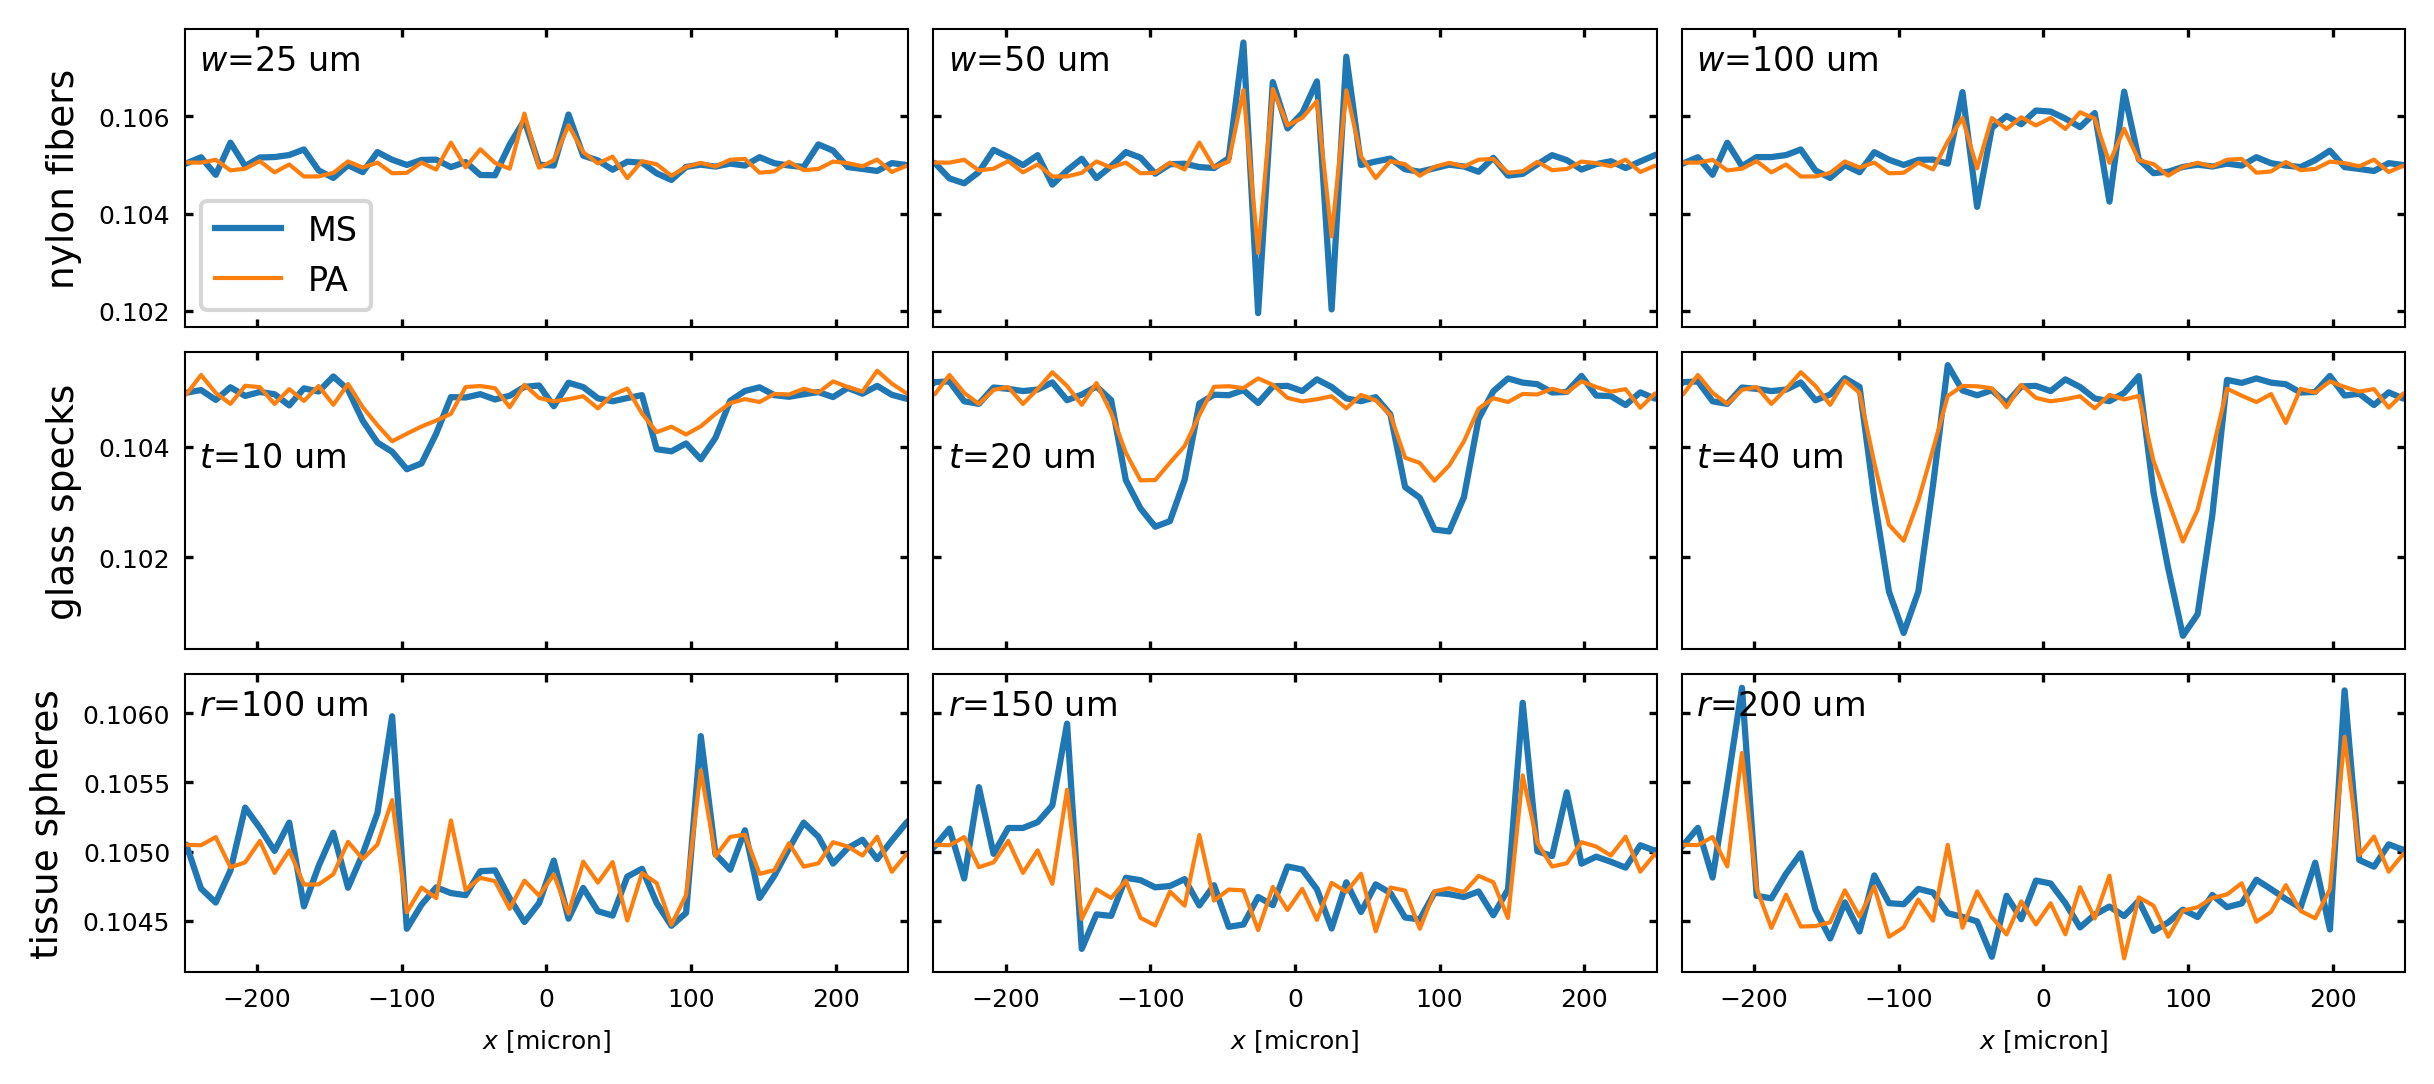

CPU times: user 4min 11s, sys: 1min 15s, total: 5min 26s
Wall time: 3min 10s


In [93]:
%%time

for NDET in [64]:    #, 128]:
    for propdist in [0, 5e-2, 10e-2]:# , 20e-2, 30e-2]:
        
        print(f'\n### {NDET}x{NDET} - {propdist*1e2:.0f} cm ###################')
        
        ##########################################
        ### Parameters 
        
        energy = 20
        I0 = 1e6 / (NDET/128)**2  # same TOTAL photons regardless of pixel size!
        
        
        # Phantom:
        N = 1024
        dx = 0.625e-6        # ~roughly half micron pixels
        fov = N*dx           # thickness in the transverse plane (x-y)
        thickness = 5e-2     # thickness along propagation axis (z)
        Nz = 100
        fib_Nz = 10    
        cyl_Nz = 10   
        sphere_Nz = 90
        fiber_thickness = 1e-3
        fiber_width_list = [25e-6, 50e-6, 100e-6] 
        speck_radius = 50e-6
        speck_thickness_list = [10e-6, 20e-6, 40e-6]
        sphere_radius_list = [100e-6, 150e-6, 200e-6] 
        
        # Detector:
        det_shape = (NDET, NDET) #(128, 128)   
        det_fov = fov                
        det_dx = det_fov / det_shape[0]  
        det_psf = 'lorentzian'  ## need to fix blurring at edge of mosaic!
        det_fwhm = 1e-6
        
        print(f'detector px = {det_dx*1e6:.1f} um, E = {energy:.0f} keV, thickness = {thickness*1e3:.1f} mm ==> NF = {NF(det_dx, energy, thickness):.2f}')
        
        fringe_crop_px = 5                               # number of pixels to crop off *each* edge of the images
        img_height = det_shape[0] - (2*fringe_crop_px)   # "height" as in number of rows
        img_width = det_shape[1] - (2*fringe_crop_px)    # "width" as in number of columns
        img_shape = (img_height, img_width)
        
        # lazy
        j = 0
        Nz_list = [Nz]
        dz = 1  # not used!!!
        
        ##########################################
        ### Fibers 
        
        fiber_store_images_approx = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
        fiber_store_images_multi = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
        for i, fiber_width in enumerate(fiber_width_list):
            print(f'fiber width = {fiber_width*1e6:.0f} micron')
        
            # use different dz for different slices -- high res in the cyl, low res out of the sphere
            fib_dz = fiber_thickness / fib_Nz
            fib_delta, fib_beta = make_fiber_phantom(N, fib_Nz, dx, fiber_width, energy, height_fraction=0.7, fiber_material=nylon, background_material=pmma)
        
            d_bg, b_bg = np.array([fib_delta.ravel()[0], fib_beta.ravel()[0]])  # assume first val is empty!!
            obj_delta = np.ones([Nz, N, N], dtype=np.float32) * d_bg
            obj_beta = np.ones([Nz, N, N], dtype=np.float32) * b_bg
            obj_delta[:fib_Nz,:,:] = fib_delta
            obj_beta[:fib_Nz,:,:] = fib_beta
            dzlist = np.zeros(Nz)
            dzlist[:fib_Nz] = fib_dz
            dzlist[fib_Nz:] = (thickness - fiber_thickness) / (Nz - fib_Nz)
        
            # Simulate with the two methods.
            beta_proj, delta_proj = np.zeros([2, N, N])
            for k in range(Nz):
                beta_proj += obj_beta[k] * dzlist[k]
                delta_proj += obj_delta[k] * dzlist[k]
            img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf) 
            fiber_store_images_approx = fiber_store_images_approx.at[i, j].set(img_approx[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])
        
            img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf, dzlist=dzlist)
            fiber_store_images_multi = fiber_store_images_multi.at[i, j].set(img_ms[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])
        
        approx_mosaic_fibers = np.hstack((fiber_store_images_approx[0][0], fiber_store_images_approx[1][0], fiber_store_images_approx[2][0]))
        multi_mosaic_fibers = np.hstack((fiber_store_images_multi[0][0], fiber_store_images_multi[1][0], fiber_store_images_multi[2][0]))
        
        
        ##########################################
        ### Cylinders 
        
        cylinder_store_images_approx = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
        cylinder_store_images_multi = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
        for i, speck_thickness in enumerate(speck_thickness_list):
            print(f'speck thickness = {speck_thickness*1e6:.0f} um')
            
            phantom_shape = jnp.array([Nz, N, N])
            
            cyl_dz = speck_thickness / cyl_Nz
            cyl_delta, cyl_beta = make_speck_phantom(N, cyl_Nz, dx, speck_radius, energy, 
                                                     speck_material=glass, background_material=pmma)
            bg_thickness = thickness - speck_thickness
            d_bg, b_bg = np.array([cyl_delta.ravel()[0], cyl_beta.ravel()[0]])  # assume first val is empty!!
            obj_delta = np.ones([Nz, N, N], dtype=np.float32) * d_bg
            obj_beta = np.ones([Nz, N, N], dtype=np.float32) * b_bg
            obj_delta[:cyl_Nz,:,:] = cyl_delta
            obj_beta[:cyl_Nz,:,:] = cyl_beta
            dzlist = np.zeros(Nz)
            dzlist[:cyl_Nz] = cyl_dz
            dzlist[cyl_Nz:] = (thickness - speck_thickness) / (Nz - cyl_Nz)
        
            beta_proj, delta_proj = np.zeros([2, N,N])
            for k in range(Nz):
                beta_proj += obj_beta[k] * dzlist[k]
                delta_proj += obj_delta[k] * dzlist[k]
            img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf)     
            cylinder_store_images_approx = cylinder_store_images_approx.at[i, j].set(img_approx[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])
        
            img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf,dzlist=dzlist)    
            cylinder_store_images_multi = cylinder_store_images_multi.at[i, j].set(img_ms[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])
        
        approx_mosaic_cylinders = np.hstack((cylinder_store_images_approx[0][0], cylinder_store_images_approx[1][0], cylinder_store_images_approx[2][0]))
        multi_mosaic_cylinders = np.hstack((cylinder_store_images_multi[0][0], cylinder_store_images_multi[1][0], cylinder_store_images_multi[2][0]))
        
        
        ##########################################
        ### Spheres 
        sphere_store_images_approx = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
        sphere_store_images_multi = jnp.zeros((len(fiber_width_list), len(Nz_list), *img_shape))
        
        for i, radius in enumerate(sphere_radius_list):
            print(f'sphere radius = {radius*1e6:.0f} micron')
            
            # Compute dependent parameters & make the phantom.
            phantom_shape = jnp.array([Nz, N, N])
        
            # use different dz for different slices -- high res in the sphere, low res out of the sphere
            sphere_thickness = 2*radius
            sphere_dz = sphere_thickness / sphere_Nz
            sph_delta, sph_beta = make_sphere_phantom(N, sphere_Nz, dx, sphere_dz, radius, energy)  # need larger Nz to resolve sphere curve
            bg_thickness = thickness - sphere_thickness
            d_bg, b_bg = sph_delta[0], sph_beta[0]  # assume first slice is empty!!
            obj_delta, obj_beta = np.zeros([2, Nz, N, N], dtype=np.float32)
            obj_delta[:sphere_Nz,:,:] = sph_delta
            obj_beta[:sphere_Nz,:,:] = sph_beta
            for k in range(sphere_Nz, Nz):
                obj_delta[k,:,:] = d_bg
                obj_beta[k,:,:] = b_bg
            dzlist = np.zeros(Nz)
            dzlist[:sphere_Nz] = sphere_dz
            dzlist[sphere_Nz:] = (thickness - sphere_thickness) / (Nz - sphere_Nz)
            
            beta_proj, delta_proj = np.zeros([2, N,N])
            for k in range(Nz):
                beta_proj += obj_beta[k] * dzlist[k]
                delta_proj += obj_delta[k] * dzlist[k]
            img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf) 
            sphere_store_images_approx = sphere_store_images_approx.at[i, j].set(img_approx[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])
        
            img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf,dzlist=dzlist)
            sphere_store_images_multi = sphere_store_images_multi.at[i, j].set(img_ms[fringe_crop_px:-fringe_crop_px, fringe_crop_px:-fringe_crop_px])
        
        approx_mosaic_spheres = np.hstack((sphere_store_images_approx[0][0], sphere_store_images_approx[1][0], sphere_store_images_approx[2][0]))
        multi_mosaic_spheres = np.hstack((sphere_store_images_multi[0][0], sphere_store_images_multi[1][0], sphere_store_images_multi[2][0]))
        
        ##########################################
        ### Show 
        # approx_mosaic_all = np.vstack((approx_mosaic_fibers, approx_mosaic_cylinders, approx_mosaic_spheres))
        # multi_mosaic_all = np.vstack((multi_mosaic_fibers, multi_mosaic_cylinders, multi_mosaic_spheres))
        
        approx_mosaic_all = np.vstack((approx_mosaic_fibers, approx_mosaic_cylinders[8:-8], approx_mosaic_spheres[3:]))   # crop for manual fig
        multi_mosaic_all = np.vstack((multi_mosaic_fibers, multi_mosaic_cylinders[8:-8], multi_mosaic_spheres[3:]))        
        
        # kw = {'cmap':'gray', 'vmin':0.099, 'vmax':0.108}  
        kw = {'cmap':'gray', 'vmin':0.10038511, 'vmax':0.10776764}  
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[7.5,3.5], dpi=300, layout='constrained')
        ax[0].set_title('projection approximation')
        m = ax[0].imshow(approx_mosaic_all, **kw)
        ax[1].set_title('multislice')
        m = ax[1].imshow(multi_mosaic_all, **kw)
        fig.colorbar(m, ax=ax, pad=0.03)
        # add_scalebar(ax[0], 0.468, det_shape[0], det_dx*1e6, 'um', color='w')
        for i in range(len(ax)):
            add_scalebar(ax[i], 0.468, det_shape[0], det_dx*1e6, 'um', color='w')
            ax[i].axis('off')
        # plt.savefig(figd+f'mosaic_{NDET}_{propdist*1e3:.0f}mm.png')
        plt.show()
        
        fig, ax = plt.subplots(1,1, figsize=[4,4], layout='constrained')
        ax.imshow(approx_mosaic_all, **kw)
        add_scalebar(ax, 0.468, det_shape[0], det_dx*1e6, 'um', color='w')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.savefig(figd+f'approx_{NDET}_{propdist*1e3:.0f}mm.png')
        plt.close()

        fig, ax = plt.subplots(1,1, figsize=[4,4], layout='constrained')
        ax.imshow(multi_mosaic_all, **kw)
        add_scalebar(ax, 0.468, det_shape[0], det_dx*1e6, 'um', color='w')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.savefig(figd+f'multi_{NDET}_{propdist*1e3:.0f}mm.png')
        plt.close()

        fsz = 9
        yloc = 0.98
        num_rows = det_shape[0] - 2*fringe_crop_px
        ms_style = '-'
        approx_style = '-'
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[8,3.5], sharey='row', sharex='col', layout='constrained')
        x = 1e6 * np.linspace(-det_fov/2, det_fov/2, det_shape[0])[fringe_crop_px:-fringe_crop_px]
        for i, width in enumerate(fiber_width_list):
            ax[0, 0].set_ylabel('nylon fibers', fontsize=fsz)
            # ax[0, i].set_title(f'$w$ = {width*1e6:.0f} um', y=yloc)
            ax[0, i].annotate(f'$w$={width*1e6:.0f} um', xy=(0.02, 0.95),xycoords='axes fraction', fontsize=8, ha='left', va='top')
            i_row = int(num_rows/2)  
            ax[0, i].plot(x, fiber_store_images_multi[i][0][i_row], ms_style, lw=1.5, label='MS')
            ax[0, i].plot(x, fiber_store_images_approx[i][0][i_row], approx_style, lw=1, label='PA')  
        for i, cyl_thickness in enumerate(speck_thickness_list):
            ax[1, 0].set_ylabel('glass specks', fontsize=fsz)
            # ax[1, i].set_title(f'$t$ = {cyl_thickness*1e6:.0f} um', y=yloc)
            ax[1, i].annotate(f'$t$={cyl_thickness*1e6:.0f} um', xy=(0.02, 0.7),xycoords='axes fraction', fontsize=8, ha='left', va='top')
        
            i_row = int(44*det_shape[0]/128)   # manually picked 44!
            ax[1, i].plot(x, cylinder_store_images_multi[i][0][i_row], ms_style, lw=1.5, label='MS')
            ax[1, i].plot(x, cylinder_store_images_approx[i][0][i_row], approx_style, lw=1, label='PA')      
        for i, width in enumerate(sphere_radius_list):
            ax[2, 0].set_ylabel('tissue spheres', fontsize=fsz)
            # ax[2, i].set_title(f'$r$ = {width*1e6:.0f} um', y=yloc)
            ax[2, i].annotate(f'$r$={width*1e6:.0f} um', xy=(0.02, 0.95),xycoords='axes fraction', fontsize=8, ha='left', va='top')
        
            i_row = int(num_rows/2)  
            ax[2, i].plot(x, sphere_store_images_multi[i][0][i_row], ms_style, lw=1.5, label='MS')
            ax[2, i].plot(x, sphere_store_images_approx[i][0][i_row], approx_style, lw=1, label='PA')  
            ax[2,i].set_xlabel('$x$ [micron]', fontsize=6)
        ax[0, 0].legend()
        for axi in ax.ravel():
        
            # axi.set_xlabel('$x$ [micron]', fontsize=6)
            axi.tick_params(axis='both', which='major', labelsize=6)
            axi.set_xlim(-250, 250)
        plt.savefig(figd+f'lines_{NDET}_{propdist*1e3:.0f}mm.png')
        plt.show()
